In [1]:
# this worksheet is meant to accompany the paper:
# "Uniquely optimal codes of low complexity are symmetric"
# by Christopher Cox, Emily J. King, Dustin G. Mixon, and Hans Parshall

# inquiries may be sent to Hans at hans.parshall@wwu.edu

# included output was generated on cocalc.com

In [2]:
# imports
import time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from itertools import permutations

# tolerance chosen for speed
epsilon = .001

In [3]:
# functions for nicely drawing trees

def interval_splitter(interval,steps):
    a = interval[0]
    b = interval[1]
    dist = (b - a)/steps
    return [[a + k*(b - a)/steps,a + (k+1)*(b - a)/steps] for k in range(steps)]

def embed_point(parentpoint,interval):
    mid = (interval[0] + interval[1]) / 2
    return list(np.array(parentpoint) + np.array([float(cos(2*pi*mid)),float(sin(2*pi*mid))]))

def embed_tree(G,root=0,interval=[0,1],origin=[0,0]):
    root_deg = G.degree(root)
    root_nbd = G.neighbors(root)
    ints = interval_splitter(interval,root_deg)
    pos = dict()
    pos[root] = origin
    H = G.copy()
    H.delete_vertex(root)
    for j in range(root_deg):
        pos[root_nbd[j]] = embed_point(pos[root],ints[j])
        if H.degree(root_nbd[j]) > 0:
            children = H.subgraph(vertices=H.connected_component_containing_vertex(root_nbd[j]))
            pos.update(embed_tree(children,root=root_nbd[j],interval=ints[j],origin=pos[root_nbd[j]]))
    return pos

def draw_tree(G,root=0):
    embedding = embed_tree(G,root=root)
    n = G.order()
    x = []
    y = []
    for key in range(n):
        x.append(embedding[key][0])
        y.append(embedding[key][1])

    lines = [[(x[i], y[i]), (x[j], y[j])] for i in range(n) for j in range(n) if G.has_edge(i,j)]
    lc = mc.LineCollection(lines, linewidths=1)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.set_aspect(1)
    ax.add_collection(lc)
    ax.scatter(x,y,color='red',edgecolor='none')
    plt.show()

def draw_tree_only(G,root=0):
    embedding = embed_tree(G,root=root)
    n = G.order()
    x = []
    y = []
    for key in range(n):
        x.append(embedding[key][0])
        y.append(embedding[key][1])

    lines = [[(x[i], y[i]), (x[j], y[j])] for i in range(n) for j in range(n) if G.has_edge(i,j)]
    lc = mc.LineCollection(lines, linewidths=1,color='black')

    fig, ax = plt.subplots()
    ax.set_aspect(1)
    ax.add_collection(lc)
    ax.scatter(x,y,color='black',zorder=3)
    xmin = ax.get_xlim()[0]
    xmax = ax.get_xlim()[1]
    ymin = ax.get_ylim()[0]
    ymax = ax.get_ylim()[1]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    fig.set_size_inches(2*(xmax-xmin), 2*(ymax-ymin))
    return fig

# solve the LP for a code of size n on a metric graph

def LP_codes(G,n):
    E = list(G.edges(labels=None))

    k = G.order()
    m = G.size()

    delta = 0
    for supp in [1,..,G.size()]:
        for P0 in Partitions(n, length=supp):
            P0 = list(P0) + [0]*(G.size() - supp)
            for p in set(list(permutations(P0))):
                P = list(p)
                LP = MixedIntegerLinearProgram(solver='GLPK')
                g = LP.new_variable(real=True,nonnegative=True)
                LP.add_constraint(g[0] >= 0)
                d = LP.new_variable(real=True,nonnegative=True)
                LP.set_objective(g[0])
                for e in G.edges(labels=False):
                    t = P[E.index(e)] # how many points on this edge
                    if t == 1:
                        LP.add_constraint(1 - d[e[0],e] - d[e[1],e] == 0)
                    elif t > 1:
                        LP.add_constraint(1 - d[e[0],e] - d[e[1],e] >= (t - 1)*g[0])
                for v in G.vertices():
                    for e1 in G.edges_incident(v,labels=False):
                        for e2 in G.edges_incident(v,labels=False):
                            if e1 != e2 and P[E.index(e1)] > 0 and P[E.index(e2)] > 0:
                                LP.add_constraint(d[v,e1] + d[v,e2] >= g[0])
                new_delta = LP.solve()
                if new_delta > delta + epsilon:
                    delta = new_delta
                    dists = dict()
                    dists['delta'] = new_delta
                    dists['weights'] = P
                    for i, v in sorted(LP.get_values(d).items()):
                        dists[i] = v
    return dists

# test if resulting code is rattle-free for uniqueness

def rattle_free(G,input_dict):
    E = list(G.edges(labels=False))
    delta = input_dict['delta']
    P = input_dict['weights']
    for e in E:
        t = P[E.index(e)]
        if  1 - input_dict[e[0],e] - input_dict[e[1],e] > (t - 1)*delta + epsilon:
            print("edge constraint not equality")
            return False
    for v in G.vertices():
        if G.degree(v) > 1:
            for e1 in G.edges_incident(v,labels=False):
                good = False
                for e2 in G.edges_incident(v,labels=False):
                    if e1 != e2:
                        if input_dict[v,e1] + input_dict[v,e2] < delta + epsilon:
                            good = True
                if not good:
                    return False
    return True

# solve the LP, visualize the result

def draw_code(G,n,d,root=0):
    num_verts = G.order()
    E = list(G.edges(labels=None))
    pos = embed_tree(G,root=root)
    x = []
    y = []
    for key in range(num_verts):
        x.append(pos[key][0])
        y.append(pos[key][1])
    lines = [[(x[i], y[i]), (x[j], y[j])] for i in range(num_verts) for j in range(num_verts) if G.has_edge(i,j)]
    delta = d['delta']
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.set_aspect(1)
    ax.scatter(x,y,color='none',edgecolor='none')
    lc = mc.LineCollection(lines, linewidths=1,color='black')
    ax.add_collection(lc)
    rigid_edge = dict()
    for e in E:
        rigid_edge[e] = True
        code_x = []
        code_y = []
        start = np.array(pos[e[0]])
        end = np.array(pos[e[1]])
        unit_vec = end - start
        start_offset = d[e[0],e]*unit_vec
        num_points = d['weights'][E.index(e)]
        code_x += [(start + start_offset + j*delta*unit_vec)[0] for j in range(num_points)]
        code_y += [(start + start_offset + j*delta*unit_vec)[1] for j in range(num_points)]
        ax.scatter(code_x,code_y,color='white',edgecolor='black',zorder=3)
        if  1 - d[e[0],e] - d[e[1],e] > (num_points - 1)*delta + epsilon:
            rigid_edge[e] = False
            continue
        red_edges = [[(code_x[i],code_y[i]), (code_x[i+1],code_y[i+1])] for i in range(num_points - 1)]
        red_lc = mc.LineCollection(red_edges, linewidths=2, color='red')
        ax.add_collection(red_lc)
    for v in G.vertices():
        red_edges = []
        if G.degree(v) > 1:
            for e1 in G.edges_incident(v,labels=False):
                for e2 in G.edges_incident(v,labels=False):
                    if e1 != e2 and rigid_edge[e1] and rigid_edge[e2]:
                        if d[v,e1] + d[v,e2] < delta + epsilon:
                            start = np.array(pos[v])
                            if v == e1[0]:
                                e1_end = np.array(pos[e1[1]])
                            else:
                                e1_end = np.array(pos[e1[0]])
                            if v == e2[0]:
                                e2_end = np.array(pos[e2[1]])
                            else:
                                e2_end = np.array(pos[e2[0]])
                            e1_unit_vec = e1_end - start
                            e2_unit_vec = e2_end - start
                            point1 = start + d[v,e1]*e1_unit_vec
                            point2 = start + d[v,e2]*e2_unit_vec
                            red_edges += [[point1,point2]]
            red_lc = mc.LineCollection(red_edges, linewidths=2, color='red')
            ax.add_collection(red_lc)
    xmin = ax.get_xlim()[0]
    xmax = ax.get_xlim()[1]
    ymin = ax.get_ylim()[0]
    ymax = ax.get_ylim()[1]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    fig.set_size_inches(2*(xmax-xmin), 2*(ymax-ymin))
    # file name:  code_|graph6|_|code|.pdf
    fig.savefig('figs/code_'+G.graph6_string()+'_'+str(n)+'.pdf', transparent=True, pad_inches=0)



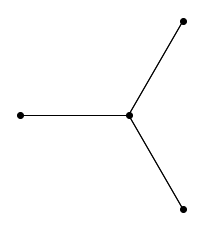

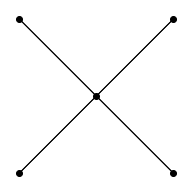

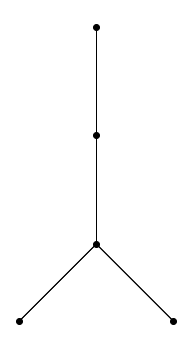

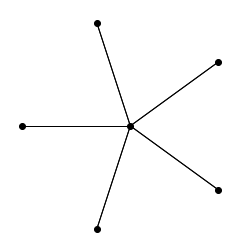

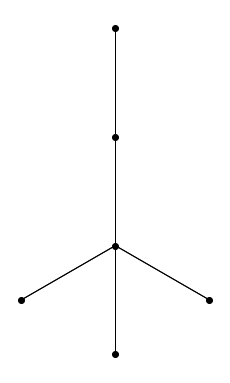

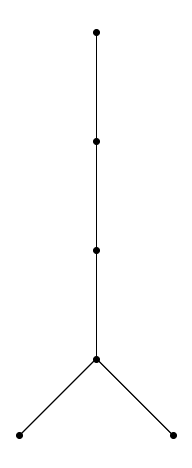

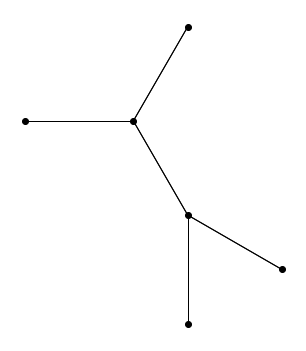

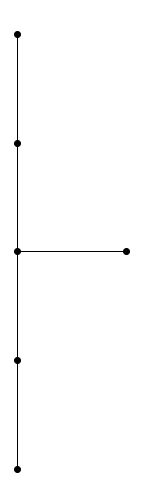

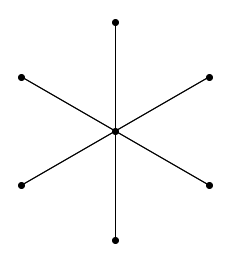

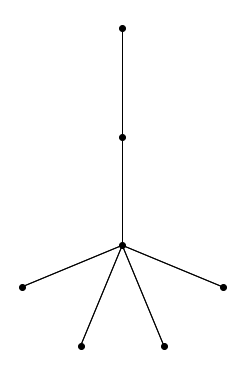

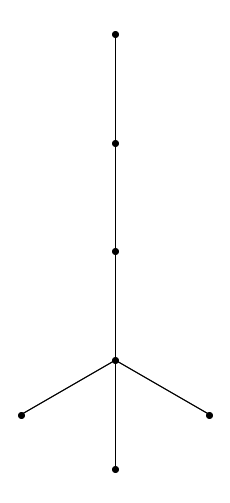

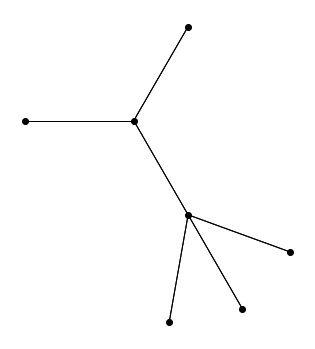

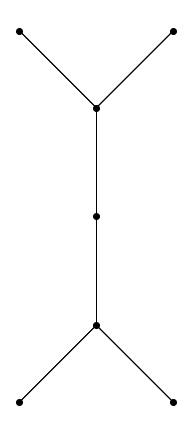

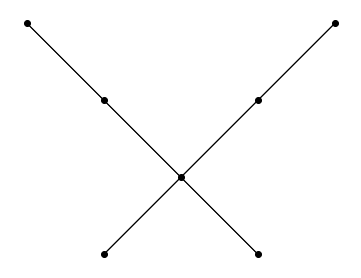

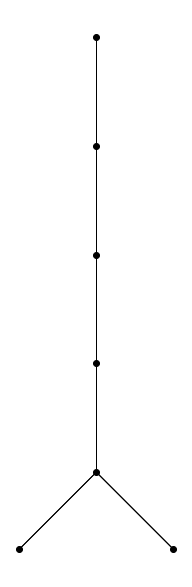

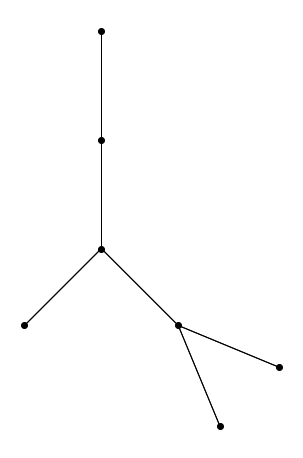

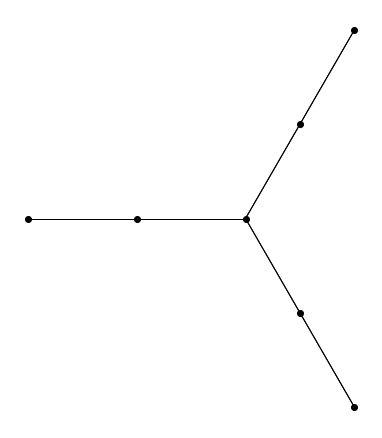

In [4]:
# draw all trees with |V| in [4,5,6,7]

for num_verts in [4,5,6,7]:
    num_edges = num_verts - 1

    for G in graphs.nauty_geng(str(num_verts) + ' ' + str(num_edges) + ':' + str(num_edges) + ' -c'):
        if not G.is_isomorphic(graphs.PathGraph(num_verts)):
            A = G.automorphism_group()
            if A.order() != 1:
                stabilizer_sizes = [0]*num_verts
                for v in G.vertices():
                    stabilizer_sizes[v] = A.stabilizer(v)
                root = stabilizer_sizes.index(max(stabilizer_sizes))
                # file name:  graph_|graph6|_|code|.pdf
                draw_tree_only(G,root).savefig('figs/graph_'+G.graph6_string()+'.pdf', transparent=True, pad_inches=0)

done with |V| = 4 in 0.33 seconds


done with |V| = 5 in 6.26 seconds


/ext/sage/sage-9.0/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


edge constraint not equality
code_6_ECR__10_1 is not rattle free!


edge constraint not equality
code_6_ECR__15_1 is not rattle free!


edge constraint not equality
code_6_ECR__20_1 is not rattle free!


edge constraint not equality
code_6_ECR__25_1 is not rattle free!


edge constraint not equality
code_6_ECR__30_1 is not rattle free!
done with |V| = 6 in 459.46 seconds


edge constraint not equality
code_7_F?`F__12_1 is not rattle free!


edge constraint not equality
code_7_F?`F__18_1 is not rattle free!


edge constraint not equality
code_7_F?`F__24_1 is not rattle free!


edge constraint not equality
code_7_F?`F__30_1 is not rattle free!


edge constraint not equality
code_7_F?`F__36_1 is not rattle free!


edge constraint not equality
code_7_F?`F__42_1 is not rattle free!


edge constraint not equality
code_7_F?`cg_12_1 is not rattle free!


edge constraint not equality
code_7_F?`cg_18_1 is not rattle free!


edge constraint not equality
code_7_F?`cg_24_1 is not rattle free!


edge constraint not equality
code_7_F?`cg_30_1 is not rattle free!


edge constraint not equality
code_7_F?`cg_36_1 is not rattle free!


edge constraint not equality
code_7_F?`cg_42_1 is not rattle free!


done with |V| = 7 in 31759.7 seconds


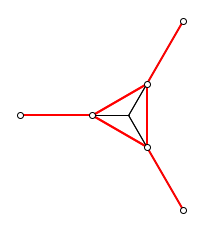

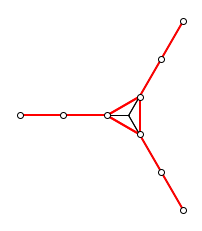

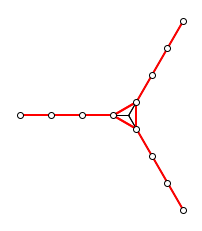

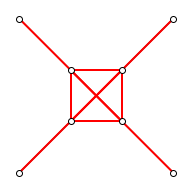

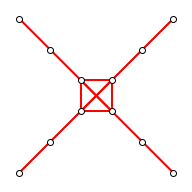

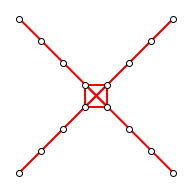

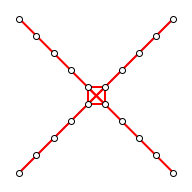

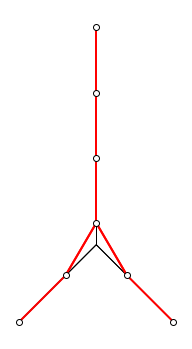

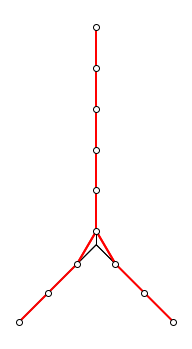

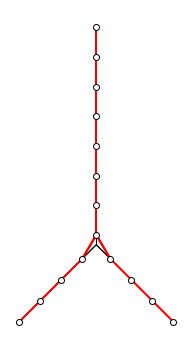

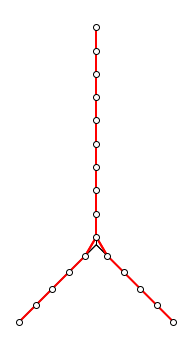

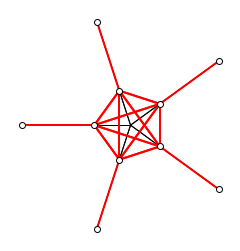

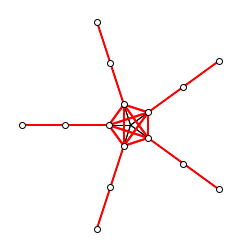

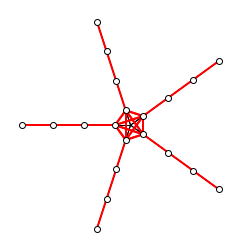

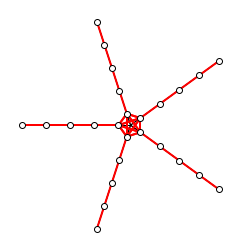

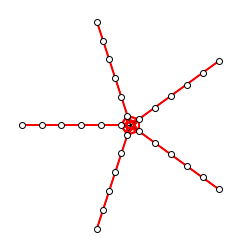

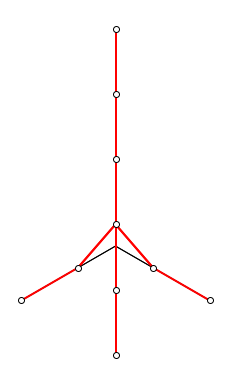

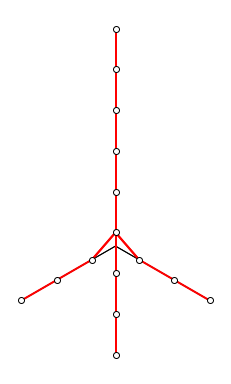

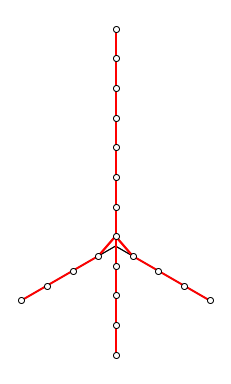

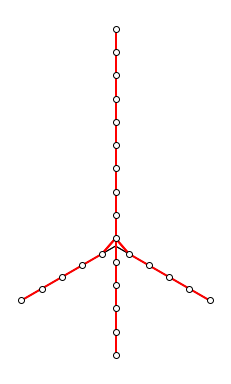

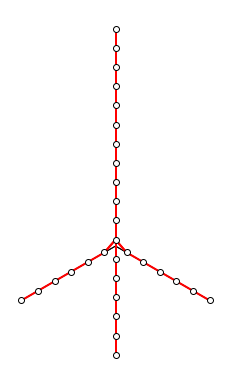

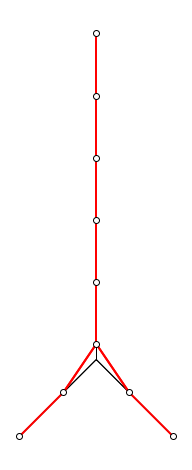

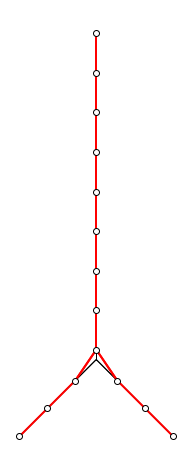

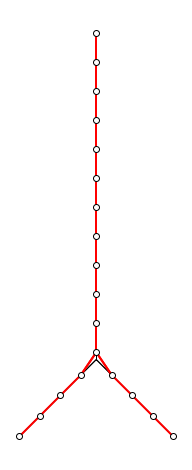

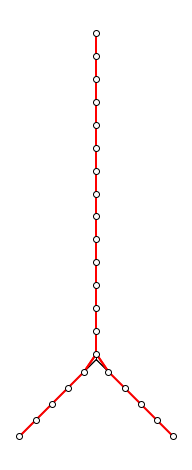

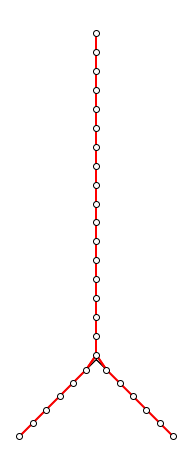

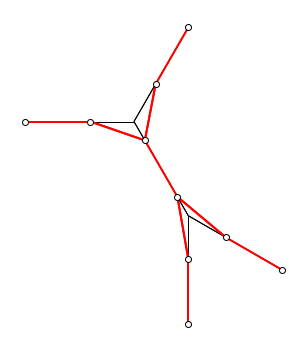

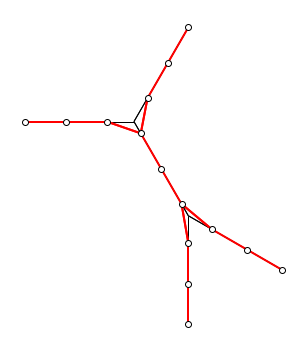

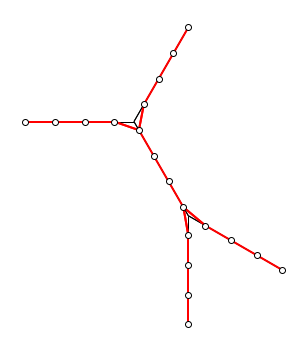

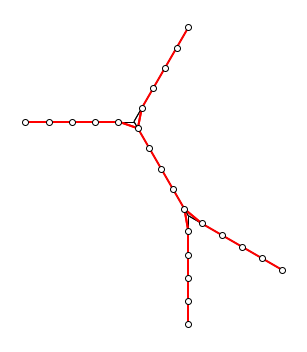

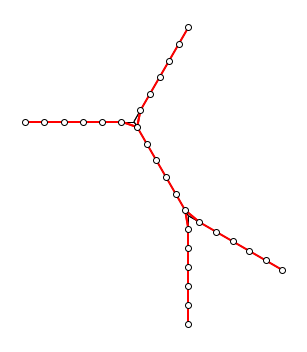

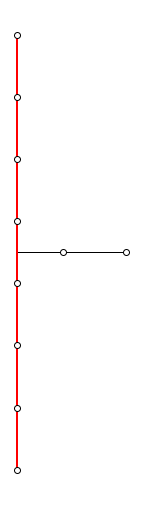

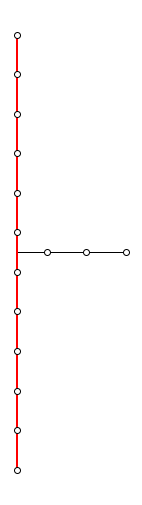

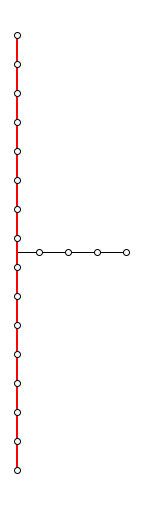

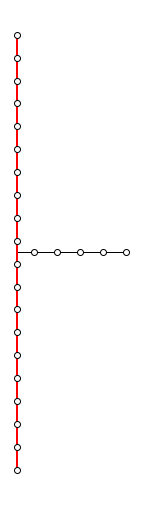

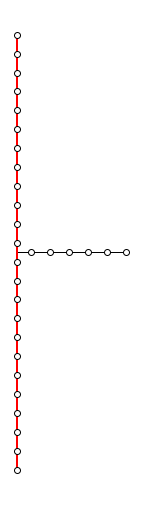

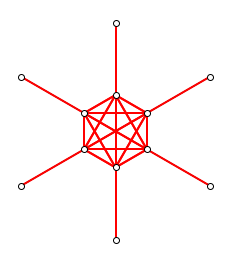

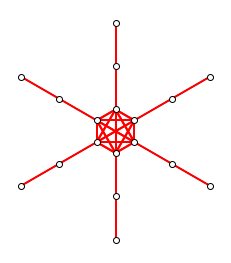

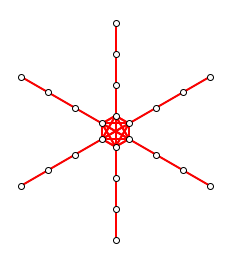

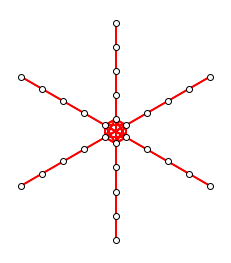

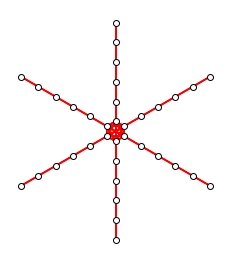

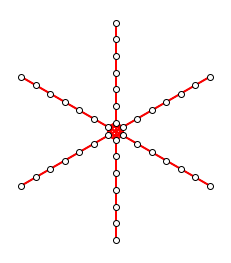

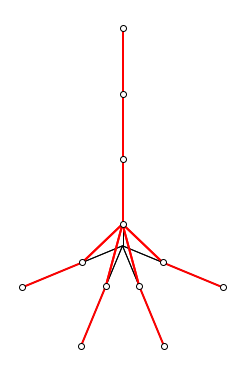

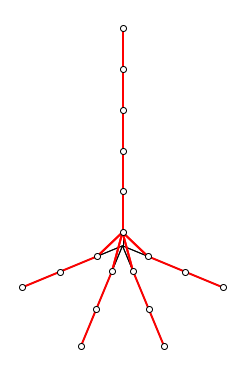

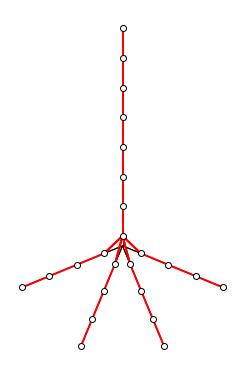

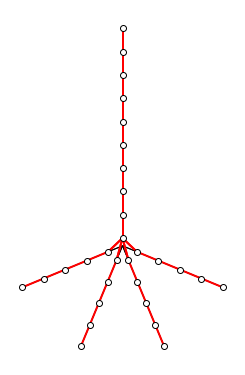

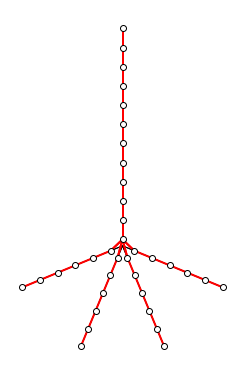

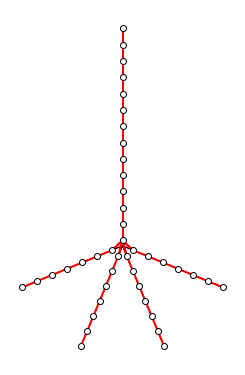

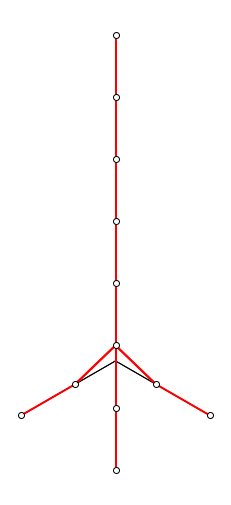

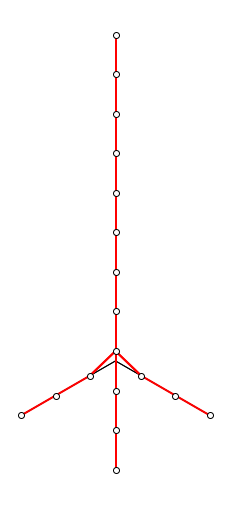

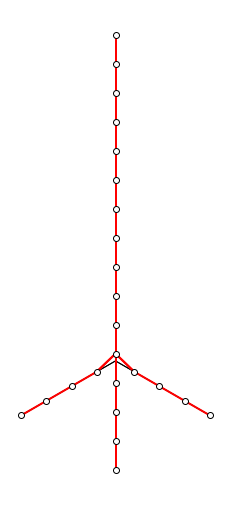

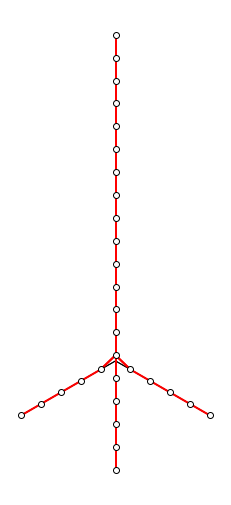

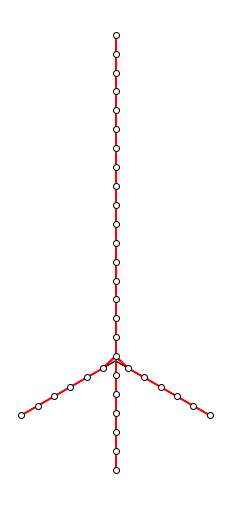

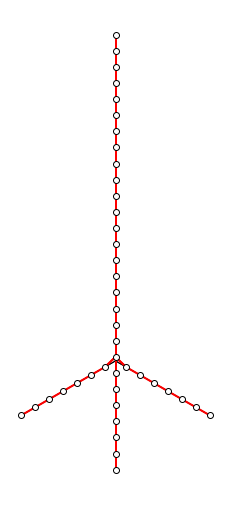

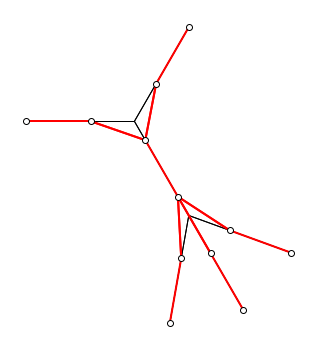

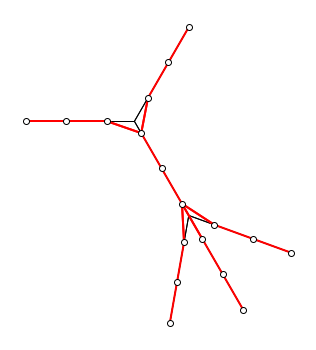

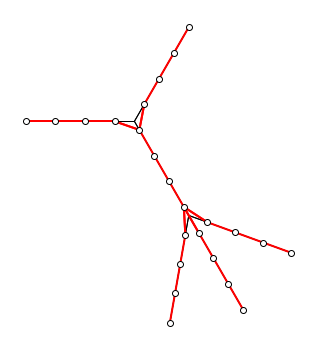

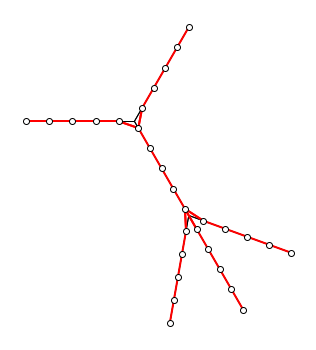

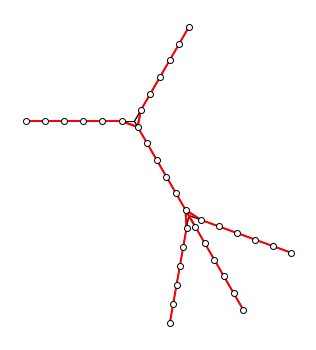

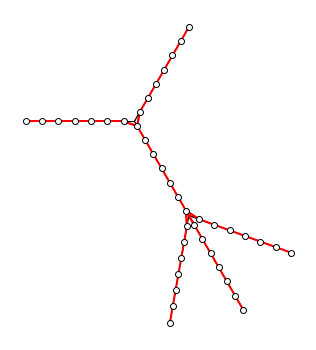

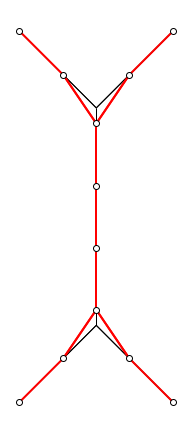

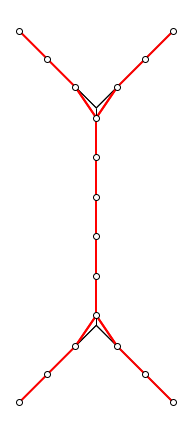

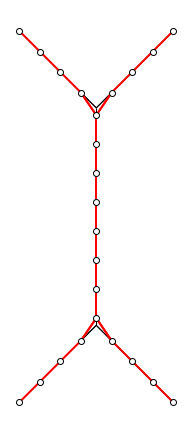

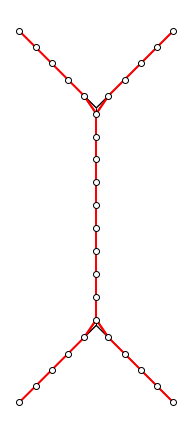

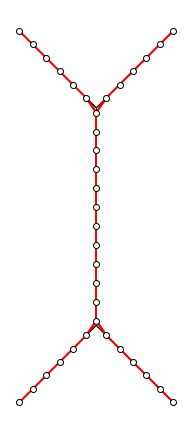

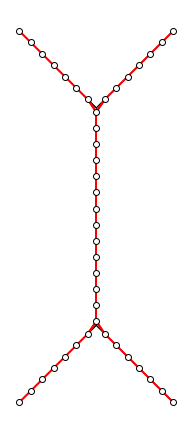

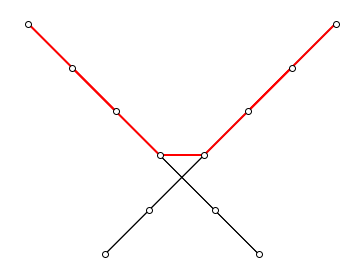

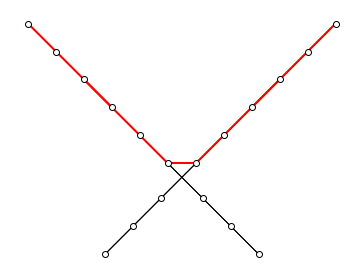

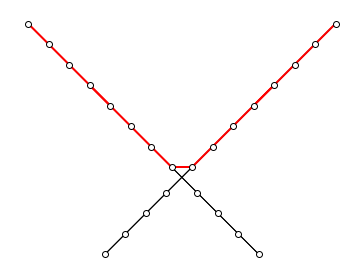

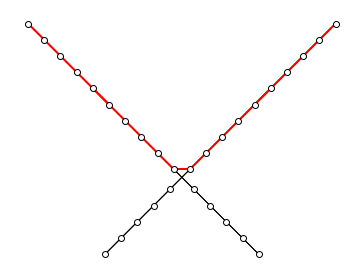

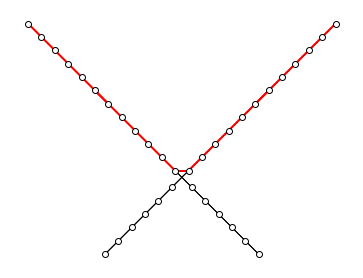

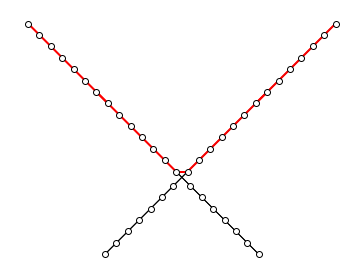

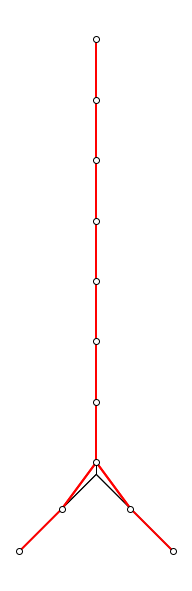

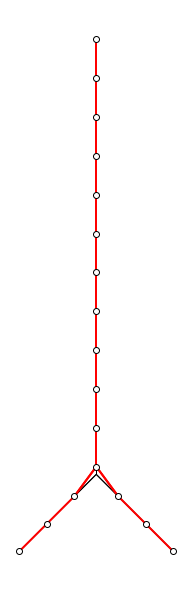

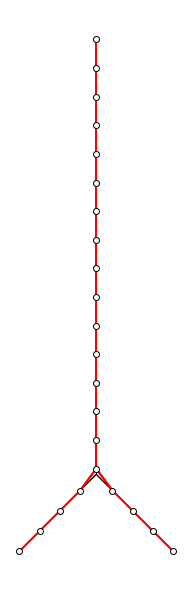

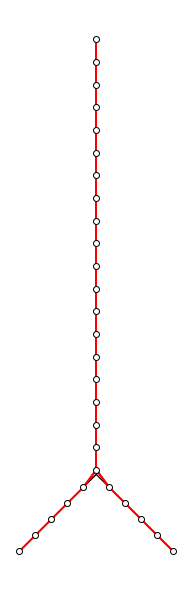

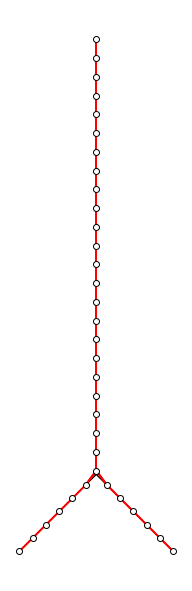

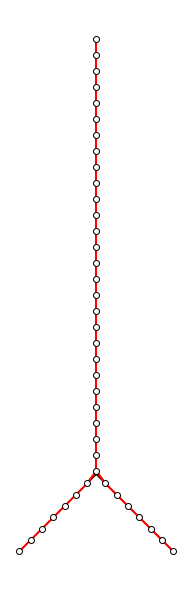

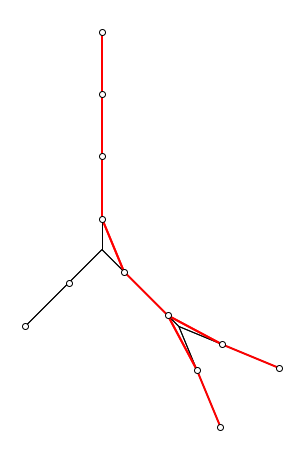

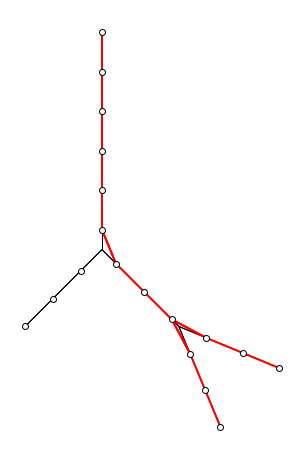

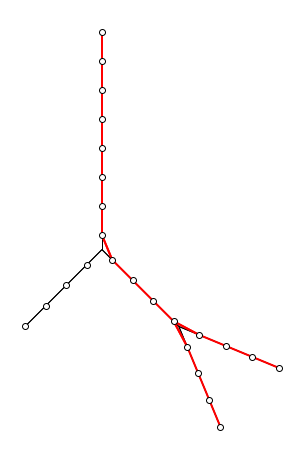

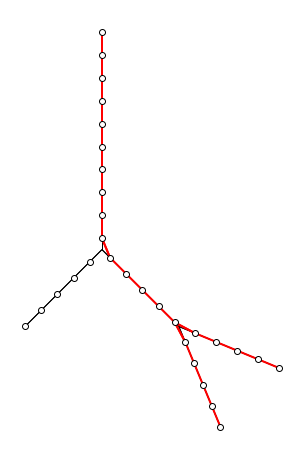

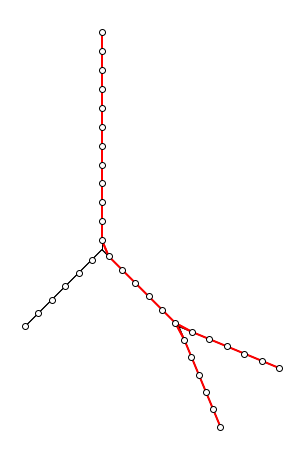

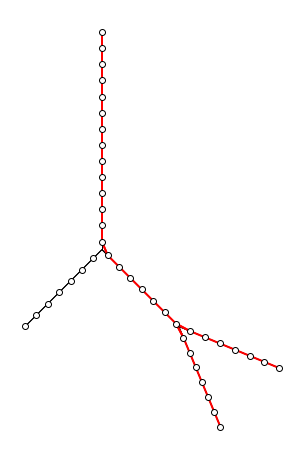

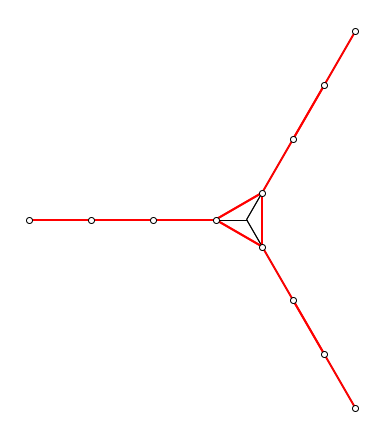

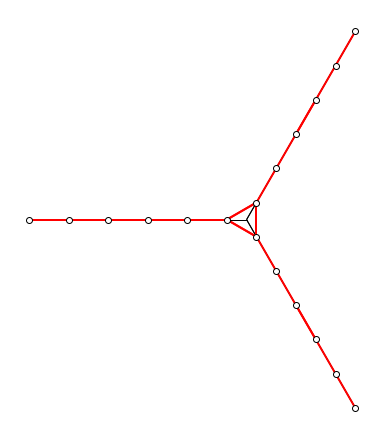

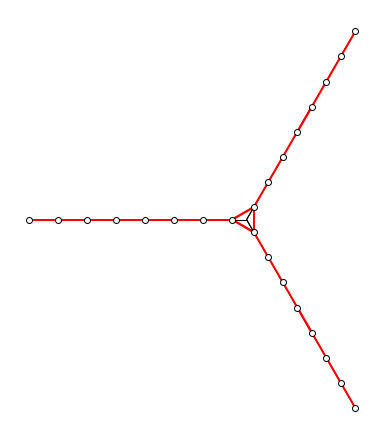

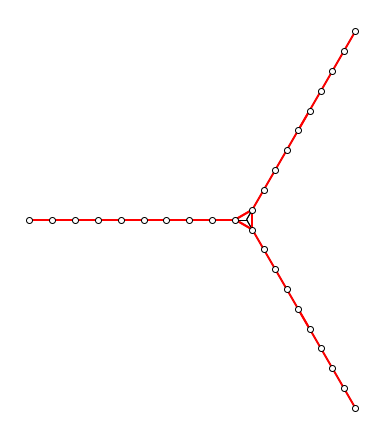

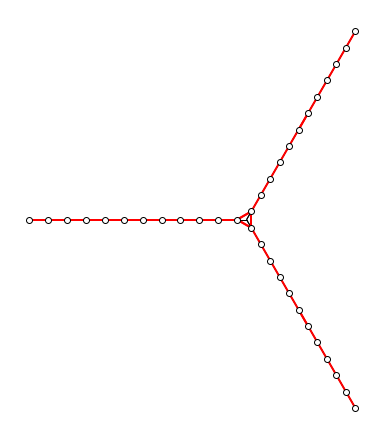

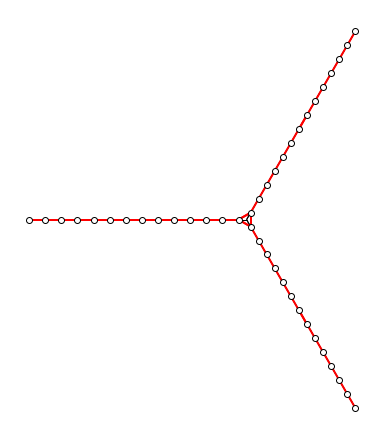

In [5]:
# we want codes of size one less than a unicorn size
# so n = |V| + k|E| - 1
# we consider trees with |V| in [4,5,6,7] and k in [1,..,|E|]

# benchmark on cocalc.com:  with num_verts = 6, the run for k = 1,..,5 takes roughly 9 minutes to find all relevant codes
# benchmark on cocalc.com:  with num_verts = 7, the run for k = 1,..,6 takes roughly 9 hours to terminate

for num_verts in [4,5,6,7]:
    start = time.time()
    num_edges = num_verts - 1
    for G in graphs.nauty_geng(str(num_verts) + ' ' + str(num_edges) + ':' + str(num_edges) + ' -c'):
        if not G.is_isomorphic(graphs.PathGraph(num_verts)):
            #G.show()
            A = G.automorphism_group()
            if A.order() != 1:
                stabilizer_sizes = [0]*num_verts
                for v in G.vertices():
                    stabilizer_sizes[v] = A.stabilizer(v)
                root = stabilizer_sizes.index(max(stabilizer_sizes))
                for k in [1,..,num_edges]:
                    n = num_verts + k*num_edges - 1
                    d = LP_codes(G,n)
                    draw_code(G,n,d,root=root)
                    count = 1
                    if rattle_free(G,d) == False:
                        print('code_'+str(num_verts)+'_'+G.graph6_string()+'_'+str(n)+'_'+str(count),'is not rattle free!')
                    count += 1
    end = time.time()
    print("done with |V| =",num_verts,"in",round(end-start,2),"seconds")